<a href="https://colab.research.google.com/github/carlmaps/Visualizaion-Projects/blob/master/SEA_Nations_COVID_19_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### SouthEast Asian Nations COVID-19 Exploratory Data Analysis
DataSource: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset

Import needed package and libraries

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly as py
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


%matplotlib inline
init_notebook_mode(connected=True)

#set default renderer to colab
pio.renderers.default = 'colab'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


My kaggle token is uploaded in google drive. Code below will download the kaggle.json file. This will be used to download the dataset from kaggle to Google Colab

In [0]:
!pip install kaggle
# Import kaggle.json from google drive
# This snippet will output a link which needs authentication from any google account
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
    q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
# print(kaggle_api_key)
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

! mkdir ~/.kaggle
! cp /content/.kaggle/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d sudalairajkumar/novel-corona-virus-2019-dataset

!mkdir covid19
!unzip novel-corona-virus-2019-dataset.zip -d covid19

Download 100%.
  0% 0.00/748k [00:00<?, ?B/s]
100% 748k/748k [00:00<00:00, 48.7MB/s]
Archive:  novel-corona-virus-2019-dataset.zip
  inflating: covid19/COVID19_line_list_data.csv  
  inflating: covid19/COVID19_open_line_list.csv  
  inflating: covid19/covid_19_data.csv  
  inflating: covid19/time_series_covid_19_confirmed.csv  
  inflating: covid19/time_series_covid_19_confirmed_US.csv  
  inflating: covid19/time_series_covid_19_deaths.csv  
  inflating: covid19/time_series_covid_19_deaths_US.csv  
  inflating: covid19/time_series_covid_19_recovered.csv  


Reading the dataset in csv to pandas dataframe

In [0]:
df = pd.read_csv('/content/covid19/covid_19_data.csv')
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


Creating a copy of the dataframe.

In [0]:
covid19_sea = df.copy(True)

Creating a list of SouthEast Asian Countries. This is then used to get the subset of the data for these countries

In [0]:
SEACountries = ['Indonesia','Thailand','Philippines','Malaysia','Singapore','Vietnam','Myanmar','Cambodia','Laos','Brunei','Timor Leste']
covid19_sea = covid19_sea[covid19_sea['Country/Region'].isin(SEACountries)]

Checking the column names

In [0]:
covid19_sea.columns

Index(['SNo', 'ObservationDate', 'Province/State', 'Country/Region',
       'Last Update', 'Confirmed', 'Deaths', 'Recovered'],
      dtype='object')

Dropping some of the columns since we wont we using them. There's no Province/State for these countries so we are dropping them as well

In [0]:
covid19_sea.drop(['SNo','Last Update', 'Province/State'], axis=1, inplace=True)

Rename columns for to a shorter name

In [0]:
covid19_sea.rename(columns={'Country/Region':'Country','ObservationDate':'Date'},inplace=True)

Run the DataFrame.info to get the details of the columns/fields which includes counts and the datatype

In [0]:
covid19_sea.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591 entries, 36 to 14986
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       591 non-null    object 
 1   Country    591 non-null    object 
 2   Confirmed  591 non-null    float64
 3   Deaths     591 non-null    float64
 4   Recovered  591 non-null    float64
dtypes: float64(3), object(2)
memory usage: 27.7+ KB


Converting the columns with float datatype to integer

In [0]:
float_cols = ['Confirmed','Deaths', 'Recovered']
for cols in list(float_cols):
  covid19_sea[cols] = covid19_sea[cols].astype('int64')

The Date column is in string format (datatype:object). Converting this to datetime datatype

In [0]:
covid19_sea['Date'] = pd.to_datetime(covid19_sea['Date'])

Running the describe() function to view statistical details of the dataset

In [0]:
covid19_sea.describe()

,Confirmed,Deaths,Recovered
count,591.000000,591.000000,591.000000
mean,509.030457,16.807107,102.157360
std,1050.023572,54.580465,282.541505
min,0.000000,0.000000,0.000000
25%,10.000000,0.000000,1.000000
50%,50.000000,0.000000,16.000000
75%,244.000000,1.000000,65.500000
max,5223.000000,459.000000,2478.000000


Creating a new column 'Cases' which is just the sum of the three columns 'Confirmed', 'Recovered', 'Deaths'

In [0]:
covid19_sea['Cases'] = df[['Confirmed', 'Recovered', 'Deaths']].sum(axis=1)
covid19_sea.head()

,Date,Country,Confirmed,Deaths,Recovered,Cases
36,2020-01-22,Thailand,2,0,0,2.0
74,2020-01-23,Thailand,3,0,0,3.0
76,2020-01-23,Singapore,1,0,0,1.0
77,2020-01-23,Philippines,0,0,0,0.0
78,2020-01-23,Malaysia,0,0,0,0.0


Since we want a time series plot. We create a pivot datsframe with Date as the index, columns will be the SouthEast Asian countries and the values for the columns will be the 'Confirmed' cases per country on that date

In [0]:
covid19_sea_pivot = covid19_sea.pivot(index='Date', columns='Country', values='Confirmed')
covid19_sea_pivot.head()

Country,Brunei,Cambodia,Indonesia,Laos,Malaysia,Philippines,Singapore,Thailand,Vietnam
Date,,,,,,,,,
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
2020-01-23,NaN,NaN,NaN,NaN,0.0,0.0,1.0,3.0,2.0
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,2.0
2020-01-25,NaN,NaN,NaN,NaN,3.0,NaN,3.0,7.0,2.0
2020-01-26,NaN,NaN,NaN,NaN,4.0,NaN,4.0,8.0,2.0


In [0]:
covid19_sea_pivot.reset_index('Date')
#covid19_sea_pivot.set_index(['Date'],inplace=True)

Country,Date,Brunei,Cambodia,Indonesia,Laos,Malaysia,Philippines,Singapore,Thailand,Vietnam
0,2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
1,2020-01-23,NaN,NaN,NaN,NaN,0.0,0.0,1.0,3.0,2.0
2,2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,2.0
3,2020-01-25,NaN,NaN,NaN,NaN,3.0,NaN,3.0,7.0,2.0
4,2020-01-26,NaN,NaN,NaN,NaN,4.0,NaN,4.0,8.0,2.0
...,...,...,...,...,...,...,...,...,...,...
79,2020-04-10,136.0,119.0,3512.0,16.0,4346.0,4195.0,2108.0,2473.0,257.0
80,2020-04-11,136.0,120.0,3842.0,18.0,4530.0,4428.0,2299.0,2518.0,258.0
81,2020-04-12,136.0,122.0,4241.0,19.0,4683.0,4648.0,2532.0,2551.0,262.0
82,2020-04-13,136.0,122.0,4557.0,19.0,4817.0,4932.0,2918.0,2579.0,265.0


After running the pivot, we can see that there are NaN. We replaced these with zero and convert each columns to integer

In [0]:
covid19_sea_pivot.fillna(0,axis=0,inplace=True)

In [0]:
countries = 'Brunei	Cambodia	Indonesia	Laos	Malaysia	Philippines	Singapore	Thailand	Vietnam'.split('\t')

In [0]:
for country in list(countries):
  covid19_sea_pivot[country] = covid19_sea_pivot[country].astype('int64')

Creating a plot a time series plot for the confirmed case for each countries

Text(2020-01-23 00:00:00, 5723, 'COVID-19 Cases of SouthEast Asian Nations')

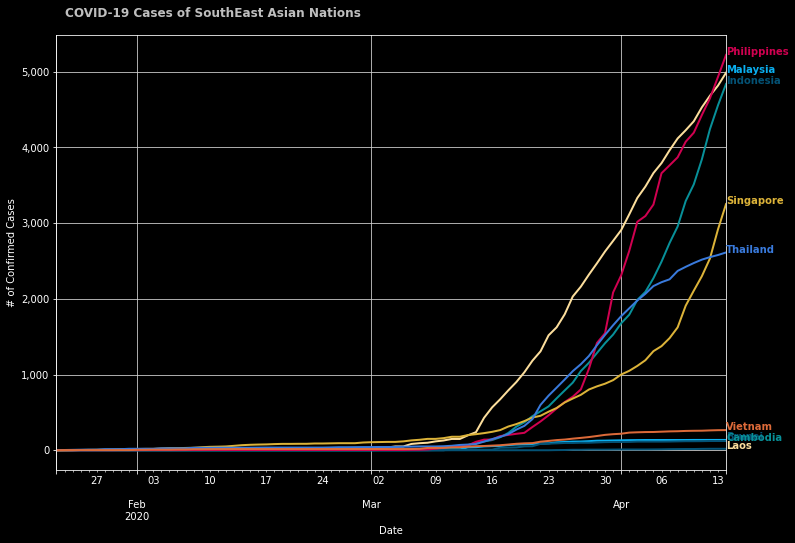

In [0]:
#list the available matplot style
#plt.style.available

#plt.style.use('tableau-colorblind10')
plt.style.use('dark_background')
colors = {'Malaysia':'#0aaff0', 'Brunei':'#045275', 'Cambodia':'#089099', 'Indonesia':'#045275', 'Laos':'#FCDE9C', 'Philippines':'#D00150','Singapore':'#dcb339','Thailand':'#397adc','Vietnam':'#dc6a39'}

plot = covid19_sea_pivot.plot(figsize=(12,8), color=list(colors.values()), linewidth=2, legend=False)
plot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plot.grid(color='#d4d4d4')
plot.set_xlabel('Date')
plot.set_ylabel('# of Confirmed Cases')

for country in list(colors.keys()):
    plot.text(x = covid19_sea_pivot.index[-1], y = covid19_sea_pivot[country].max(), color = colors[country], s = country, weight = 'bold')

plot.text(x = covid19_sea_pivot.index[1], y = int(covid19_sea_pivot.max().max())+500, s = "COVID-19 Cases of SouthEast Asian Nations", fontsize = 12, weight = 'bold', alpha = .75)

In [0]:
colors['Vietnam']

'#dc6a39'

Creating a dictionary of countries and the current population. 
Computing the spread per 100000 population

In [0]:

#create a population variable which contain a dictionary of population per country
population = {'Brunei':437479, 'Cambodia':16718965, 'Indonesia':273523615, 'Laos':7275560, 'Malaysia':32365999, 'Philippines':109581078, 'Singapore':5850342, 'Thailand':69799978, 'Vietnam':97338579,}

covid_perCapita = covid19_sea_pivot.copy()

for country in list(covid_perCapita.columns):
  #compute the cases per 100,000 people
  covid_perCapita[country] = (covid_perCapita[country]/population[country])*100000

Creating a plot a time series plot for the covid cases spread per 100000 population for each countries

Text(2020-01-23 00:00:00, 60, '(Number of Cases / Population) * 100000')

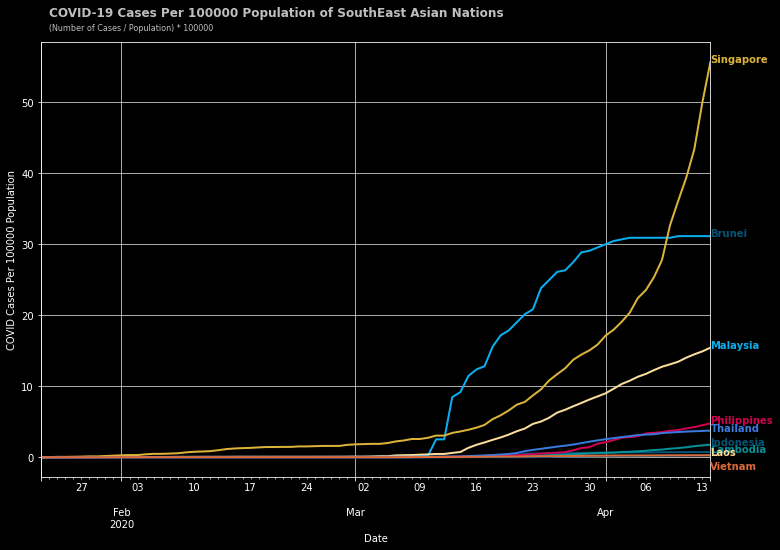

In [0]:
#list the available matplot style
#plt.style.available

#plt.style.use('tableau-colorblind10')
plt.style.use('dark_background')
colors = {'Malaysia':'#0aaff0', 'Brunei':'#045275', 'Cambodia':'#089099', 'Indonesia':'#045275', 'Laos':'#FCDE9C', 'Philippines':'#D00150','Singapore':'#dcb339','Thailand':'#397adc','Vietnam':'#dc6a39'}

plot = covid_perCapita.plot(figsize=(12,8), color=list(colors.values()), linewidth=2, legend=False)
plot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plot.grid(color='#d4d4d4')
plot.set_xlabel('Date')
plot.set_ylabel('COVID Cases Per 100000 Population')

for country in list(colors.keys()):
  if country == 'Vietnam':
    plot.text(x = covid_perCapita.index[-1], y = covid_perCapita[country].max()-2, color = colors[country], s = country, weight = 'bold')
  else:
    plot.text(x = covid_perCapita.index[-1], y = covid_perCapita[country].max(), color = colors[country], s = country, weight = 'bold')

plot.text(x = covid_perCapita.index[1], y = int(covid_perCapita.max().max())+7, s = "COVID-19 Cases Per 100000 Population of SouthEast Asian Nations", fontsize = 12, weight = 'bold', alpha = .75)
plot.text(x = covid_perCapita.index[1], y = int(covid_perCapita.max().max())+5, s = "(Number of Cases / Population) * 100000", fontsize = 8, alpha = .75)